# Airbnb in Seattle

Through this notebook, Data of Airbnb in Seattle is to be analazed for some business questions. This analysis follows CRISP-DM process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import graphviz
import re

%matplotlib inline

Airbnb seattle data is available here:  
https://www.kaggle.com/airbnb/seattle/data  
Listings : Attributes and ratings of listings  
Calendar : Availability and price of each listing and each day  
Reviews : Reviewers, review dates and comments for each listing

## Business Understanding


Airbnb is an online platform where those who need accommodations and those who want to offer ones can meet each other. On the platform, a host can list his/her own properties on the market. A vistor will pick a property from the list which he/she prefers, visit and stay there, and then write reviews or comments about the stay. Price is determined for each night and could be changed day by day.

## Data Understanding

There are three data files (listings, calendar, reviews). This analysis is to use listings and calendar.

In [2]:
listings_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv')

Let's take a look at overview of listings.

In [3]:
listings_df.shape

(3818, 92)

In [4]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
listings_df.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

(array([6.470e+02, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 3.000e+00,
        2.000e+01, 4.200e+01, 3.560e+02, 2.745e+03]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

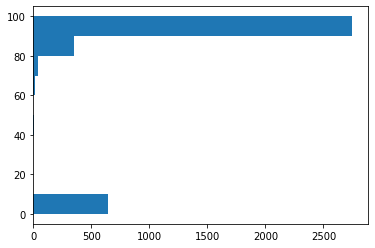

In [6]:
plt.hist(listings_df["review_scores_rating"].fillna(value=0),orientation="horizontal")

In [7]:
# check the columns which have null values
listings_df.isnull().sum().sort_values(ascending=False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
accommodates           0
bed_type               0
amenities              0
price                  0
id                     0
Length: 92, dtype: int64

In [8]:
listings_df['jurisdiction_names'].unique().size

1

In [9]:
# check columns which have only a single unique value
single_value_columns = []
for col in listings_df.columns:
    if listings_df[col].unique().size == 1:
        single_value_columns.append(col)
print(single_value_columns)


['scrape_id', 'last_scraped', 'experiences_offered', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names']


Also let's take a look at calendar.

In [10]:
calendar_df.shape

(1393570, 4)

In [11]:
calendar_df.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

(array([212153., 307019., 140037., 128398.,  72532.,   8929.,  39306.,
         11205.,  12579.,   2384.]),
 array([  0. ,  66.8, 133.6, 200.4, 267.2, 334. , 400.8, 467.6, 534.4,
        601.2, 668. ]),
 <a list of 10 Patch objects>)

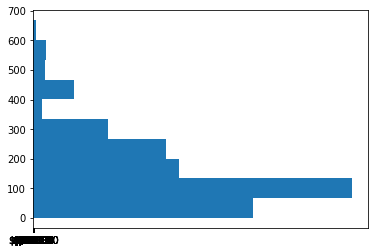

In [12]:
plt.hist(calendar_df["price"].dropna(),orientation="horizontal")

## Prepare Data

### Selecte columns which seem relevant

I will use only the columns which seem to have meaningful values

In [13]:
listings_df_sel = listings_df[[
     'id'
    ,'bed_type'
    ,'cancellation_policy'
    ,'neighbourhood_group_cleansed'
    ,'property_type'
    ,'reviews_per_month'
    ,'number_of_reviews'
    ,'room_type'
    ,'bedrooms'
    ,'bathrooms'
    ,'beds'
    ,'guests_included'
    ,'review_scores_rating'
    ,'amenities'
]]

In [14]:
listings_df_sel.head()

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,7421966,Real Bed,flexible,Queen Anne,Apartment,NaN,0,Entire home/apt,0.0,1.0,2.0,1,NaN,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


### Handle missing data

In [15]:
# check number of rows
listings_df_sel.shape[0]

3818

In [16]:
# remove listings which do not have rating
listings_df_cl = listings_df_sel.dropna(subset=['review_scores_rating']).copy()
listings_df_cl.shape[0]

3171

In [17]:
listings_df_cl.isnull().sum().sort_values(ascending=False)

bathrooms                       12
bedrooms                         6
amenities                        0
review_scores_rating             0
guests_included                  0
beds                             0
room_type                        0
number_of_reviews                0
reviews_per_month                0
property_type                    0
neighbourhood_group_cleansed     0
cancellation_policy              0
bed_type                         0
id                               0
dtype: int64

In [18]:
# handle missing value for bathrooms
listings_df_cl['bathrooms'].value_counts()

1.0    2414
2.0     304
1.5     203
2.5      97
3.0      53
3.5      50
0.5      21
4.0       6
0.0       4
4.5       3
5.0       2
8.0       2
Name: bathrooms, dtype: int64

In [19]:
# put 0 for bathrooms where value is missing
listings_df_cl['bathrooms'] = listings_df_cl['bathrooms'].fillna(value=0)

In [20]:
listings_df_cl['bedrooms'].value_counts()

1.0    2013
2.0     533
0.0     307
3.0     236
4.0      52
5.0      17
6.0       6
7.0       1
Name: bedrooms, dtype: int64

In [21]:
# put 0 for bedrooms where value is missing
listings_df_cl['bedrooms'] = listings_df_cl['bedrooms'].fillna(value=0)

In [22]:
listings_df_cl.head()

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
5,5956968,Real Bed,strict,Queen Anne,House,2.45,17,Private room,1.0,1.0,1.0,1,95.0,"{""Wireless Internet"",""Free Parking on Premises..."


### Handle categorical data

In [23]:
listings_df_cl

,id,bed_type,cancellation_policy,neighbourhood_group_cleansed,property_type,reviews_per_month,number_of_reviews,room_type,bedrooms,bathrooms,beds,guests_included,review_scores_rating,amenities
0,241032,Real Bed,moderate,Queen Anne,Apartment,4.07,207,Entire home/apt,1.0,1.0,1.0,2,95.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Real Bed,strict,Queen Anne,Apartment,1.48,43,Entire home/apt,1.0,1.0,1.0,1,96.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,Real Bed,strict,Queen Anne,House,1.15,20,Entire home/apt,5.0,4.5,7.0,10,97.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
4,278830,Real Bed,strict,Queen Anne,House,0.89,38,Entire home/apt,3.0,2.0,3.0,6,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
5,5956968,Real Bed,strict,Queen Anne,House,2.45,17,Private room,1.0,1.0,1.0,1,95.0,"{""Wireless Internet"",""Free Parking on Premises..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,262764,Real Bed,strict,Other neighborhoods,House,1.56,5,Entire home/apt,2.0,1.0,3.0,4,92.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
3811,8578490,Real Bed,moderate,Other neighborhoods,Apartment,0.63,2,Entire home/apt,1.0,1.0,1.0,1,100.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3812,3383329,Real Bed,moderate,Other neighborhoods,Apartment,4.01,73,Entire home/apt,1.0,1.0,2.0,2,96.0,"{Internet,""Wireless Internet"",Kitchen,""Free Pa..."
3813,8101950,Real Bed,strict,Other neighborhoods,House,0.30,1,Entire home/apt,3.0,2.0,3.0,1,80.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."


In [24]:
listings_df_dum = listings_df_cl.copy()

# get dummy columns for categorical columns
for col in ['bed_type','cancellation_policy','neighbourhood_group_cleansed','property_type','room_type']:
    listings_df_dum = pd.concat([listings_df_dum.drop(col,axis=1), pd.get_dummies(listings_df_dum[col],col)],axis=1)

# get unique amenities
amenities = []
for line in listings_df_cl['amenities']:
    amenities.extend(re.sub('["{}]','',line).split(','))
unique_amenities = set(amenities)

# add dummy columns for amenities
for amenity in unique_amenities:
    listings_df_dum['amenities_' + amenity] = \
        listings_df_cl['amenities'].apply(lambda line:1 if amenity in re.sub('["{}]','',line).split(',') else 0)

listings_df_dum = listings_df_dum.drop('amenities',axis=1)

In [25]:
listings_df_dum.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Carbon Monoxide Detector,amenities_Pets live on this property,amenities_Hangers,amenities_Internet,amenities_Laptop Friendly Workspace,amenities_Indoor Fireplace,amenities_TV,amenities_Family/Kid Friendly,amenities_Washer / Dryer,amenities_Dryer
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,0,0,0,1,0,0,1,1,0,1
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,1,0,0,1,0,0,1,1,0,1
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,1,1,0,1,0,1,1,1,0,1
4,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,1,0,0,1,0,0,1,1,0,0
5,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Format data

In [26]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [27]:
# format values of calendar_df
calendar_df_cl = pd.DataFrame()
calendar_df_cl['listing_id'] = calendar_df['listing_id']
calendar_df_cl['date'] = pd.to_datetime(calendar_df['date'])
calendar_df_cl['available'] = calendar_df['available'].apply(lambda s:True if s=='t' else False)
calendar_df_cl['price'] = calendar_df['price'].apply(lambda s:np.nan if s is np.nan else float(s.replace('$','').replace(',','')))

In [28]:
calendar_df_cl.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


In [29]:
calendar_df_agg = calendar_df_cl[calendar_df_cl['available']==True]\
    .groupby('listing_id')['price'].mean().to_frame()\
    .reset_index()

In [30]:
calendar_df_agg.head()

,listing_id,price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000


### Merge listings and calendar data

In [31]:
merged_df = pd.merge(listings_df_dum,calendar_df_agg
         ,how='inner'
         ,left_on='id'
         ,right_on='listing_id')
merged_df.to_csv('data/merged.csv')
merged_df.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Hangers,amenities_Internet,amenities_Laptop Friendly Workspace,amenities_Indoor Fireplace,amenities_TV,amenities_Family/Kid Friendly,amenities_Washer / Dryer,amenities_Dryer,listing_id,price
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,0,1,0,0,1,1,0,1,241032,85.000000
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,0,1,0,0,1,1,0,1,953595,170.931271
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,0,1,0,1,1,1,0,1,3308979,1301.818182
3,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,0,1,0,0,1,1,0,0,278830,462.739726
4,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,0,0,0,0,0,0,0,0,5956968,125.629139


# How should I set price?

## Data Modeling

In [32]:
def modeling(X,y):
    """This function takes care of splitting data into training and test, generating and 
    fitting machine learning model based on decision tree regressor argorithms, and verifying
    the model with r2 squarered score.
    Args:
        X(array-like): explanatory variables for prediction
        y(array-like): list of target variable
    Returns:
        X_train(array): train data for X
        y_train(array): train data for X
        X_test(array): train data for y
        y_test(array): train data for y
        model: DecisionTreeRegressor model which is generated and fit
        r2(float): r2 squared score caluclated with X and y
    """
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
    
    model = DecisionTreeRegressor(max_depth=5,min_samples_leaf=6)
    model.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    r2 = r2_score(y_test,y_test_pred)
    return X_train, y_train, X_test, y_test, model, r2

In [33]:
X = merged_df.drop(['review_scores_rating','reviews_per_month','id','listing_id','price'],axis=1)
y = merged_df['price']

In [34]:
X_train, y_train, X_test, y_test, model, r2 = modeling(X,y)

## Evaluate the Results

In [35]:
r2

0.5611397082945133

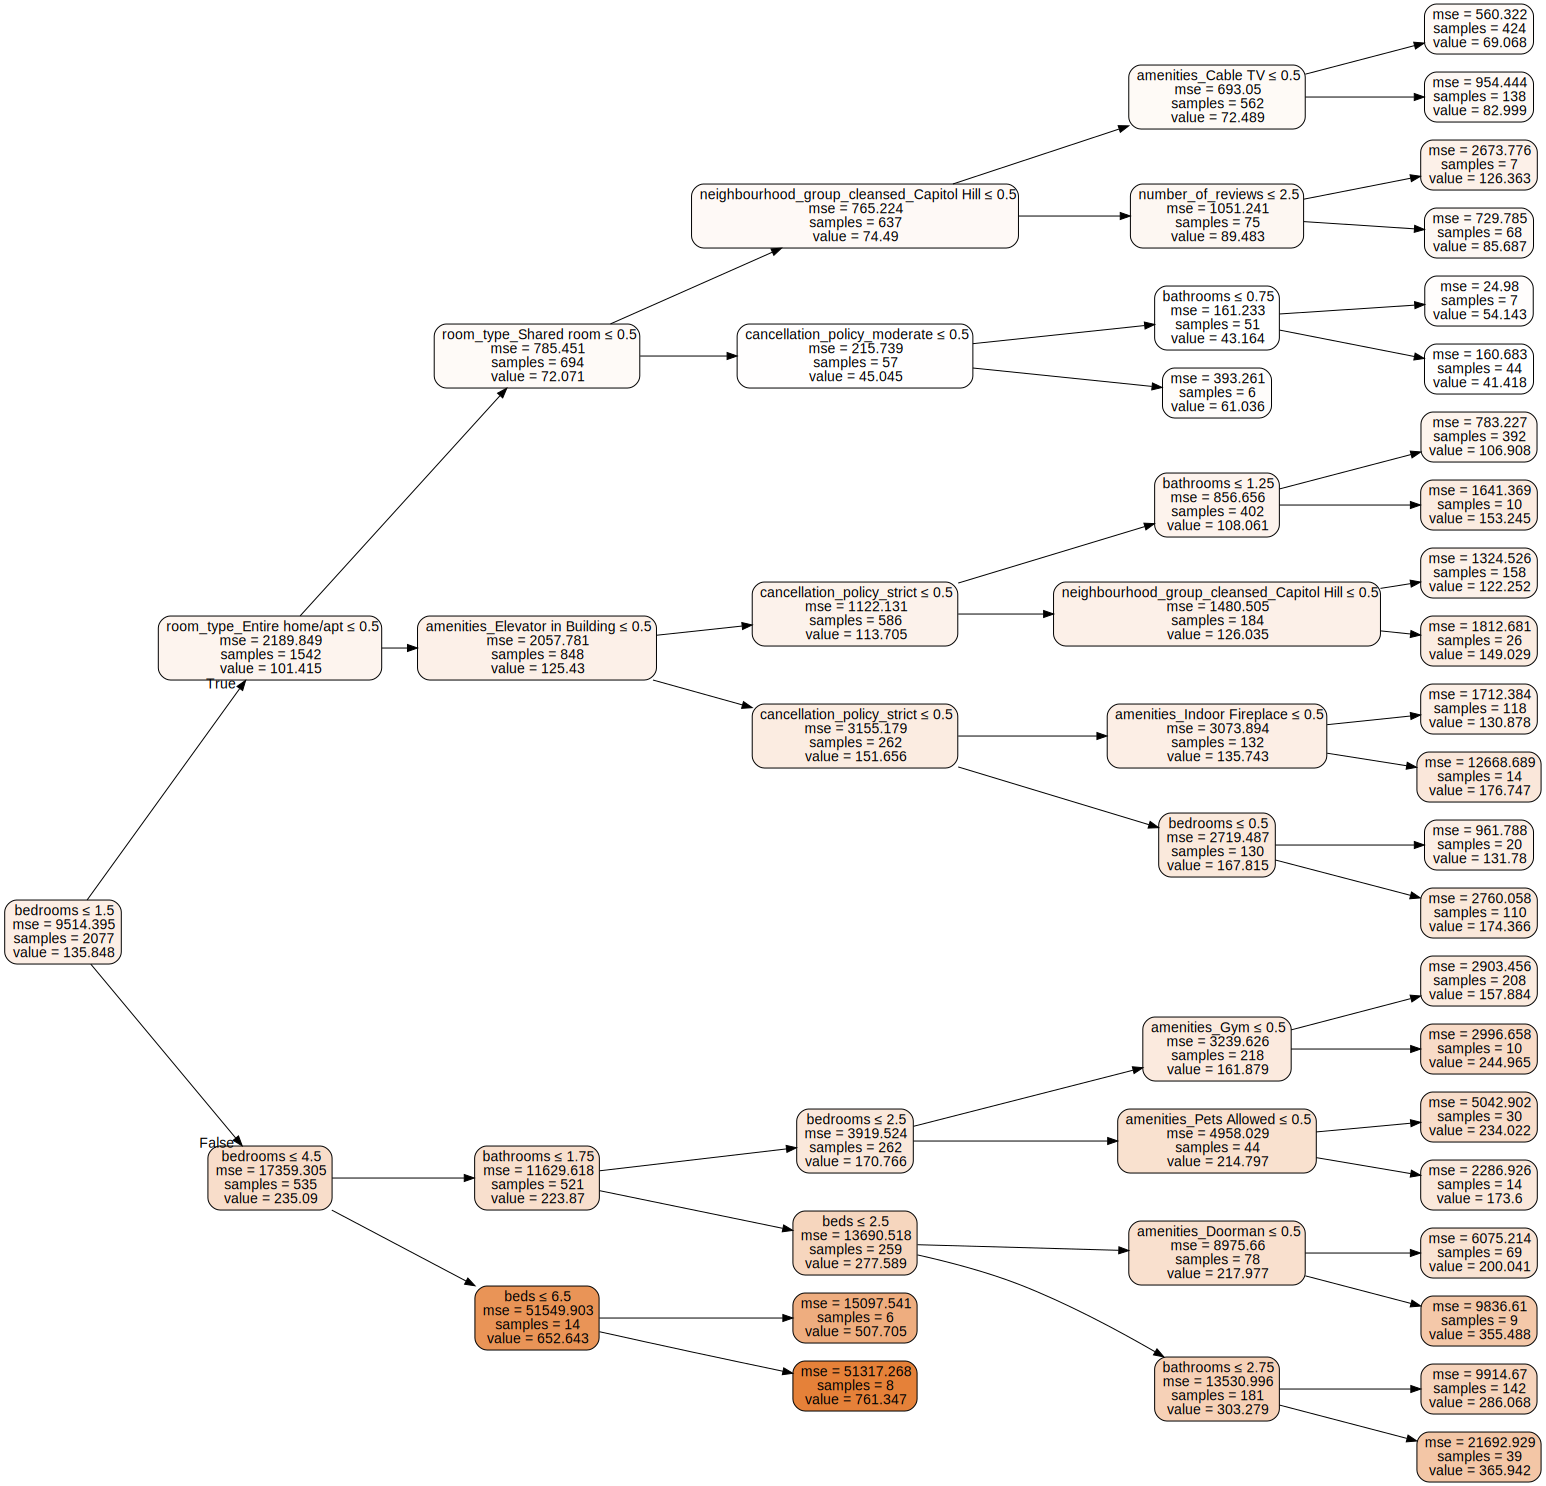

In [36]:
# output a png file
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=X.columns,  
                       
                     filled=True, rounded=True,  
                     special_characters=True,
                               rotate=True)  

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('result/pricing_tree',cleanup=True)
graph

# How I can get good ratings?

## Data Modeling

In [37]:
merged_df.head()

,id,reviews_per_month,number_of_reviews,bedrooms,bathrooms,beds,guests_included,review_scores_rating,bed_type_Airbed,bed_type_Couch,...,amenities_Hangers,amenities_Internet,amenities_Laptop Friendly Workspace,amenities_Indoor Fireplace,amenities_TV,amenities_Family/Kid Friendly,amenities_Washer / Dryer,amenities_Dryer,listing_id,price
0,241032,4.07,207,1.0,1.0,1.0,2,95.0,0,0,...,0,1,0,0,1,1,0,1,241032,85.000000
1,953595,1.48,43,1.0,1.0,1.0,1,96.0,0,0,...,0,1,0,0,1,1,0,1,953595,170.931271
2,3308979,1.15,20,5.0,4.5,7.0,10,97.0,0,0,...,0,1,0,1,1,1,0,1,3308979,1301.818182
3,278830,0.89,38,3.0,2.0,3.0,6,92.0,0,0,...,0,1,0,0,1,1,0,0,278830,462.739726
4,5956968,2.45,17,1.0,1.0,1.0,1,95.0,0,0,...,0,0,0,0,0,0,0,0,5956968,125.629139


In [38]:
X_columns = []
X_columns.extend(filter(lambda column:'amenities' in column,merged_df.columns))
X_columns.extend(filter(lambda column:'neighbourhood_group' in column,merged_df.columns))

X = merged_df[X_columns]
y = merged_df['review_scores_rating']

X_train, y_train, X_test, y_test, model, r2 = modeling(X,y)

## Evaluate the Results

In [39]:
print(r2)

0.0773084028480453


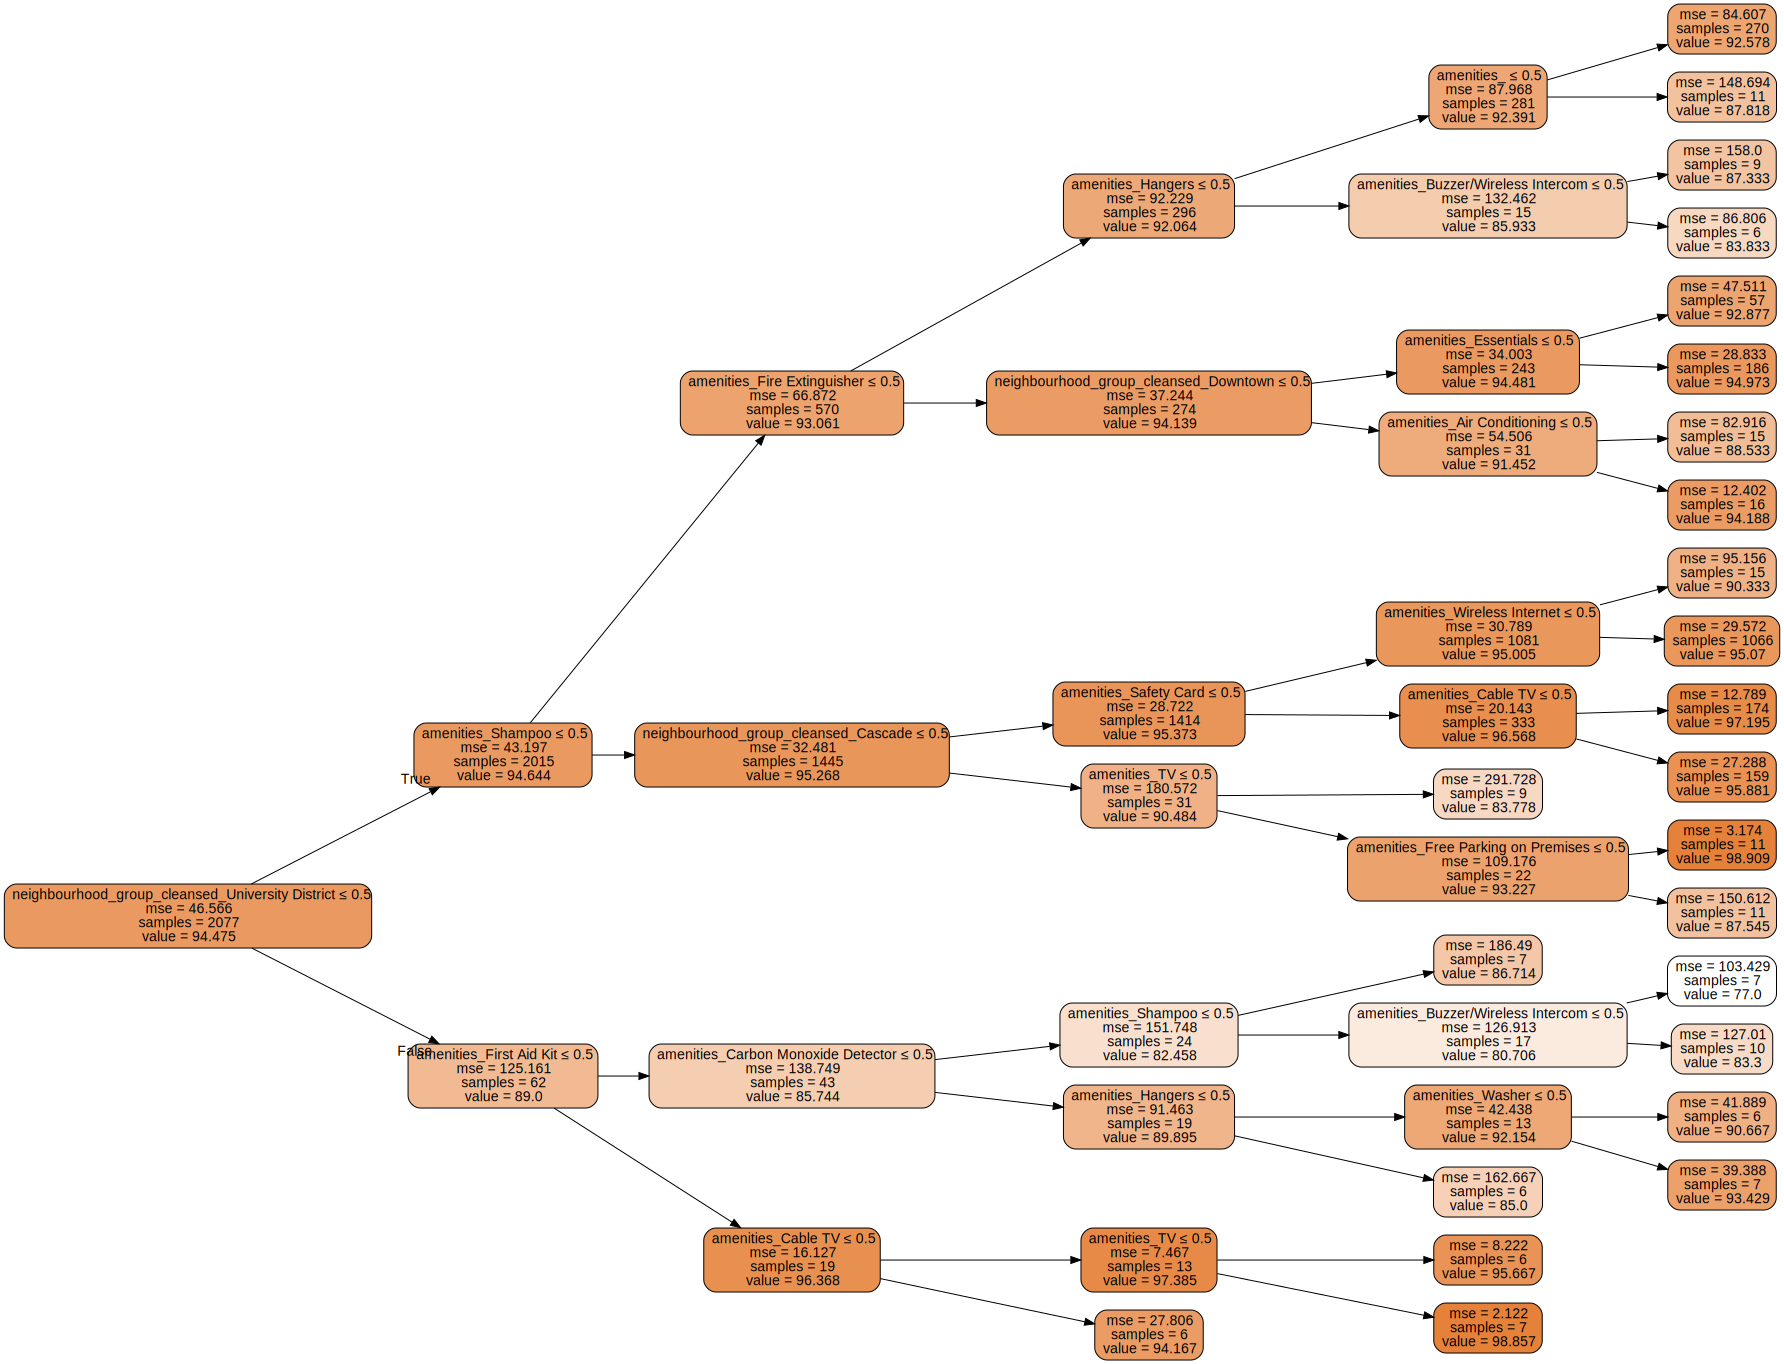

In [40]:
# output a png file
dot_data = tree.export_graphviz(model, out_file=None, 
                     feature_names=X.columns,  
                       
                     filled=True, rounded=True,  
                     special_characters=True,
                               rotate=True)  

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('result/rating_tree',cleanup=True)
graph